In [45]:
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, RandomSampler
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from pathlib import Path
import cv2
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F

In [46]:
def check_jpg_counts(path):
    cnt = 0
    for dir_name in os.listdir(path):
        dir_path = os.path.join(path, dir_name)
        if os.path.isdir(dir_path):
            jpg_count = sum(1 for f in os.listdir(dir_path) if f.endswith(".jpg"))
            if jpg_count != 170:
                print(f"file {dir_name} has {jpg_count} number .jpg")
            cnt += jpg_count
    print('other files each 170 number .jpg')
    print(f"total {cnt} number .jpg")


_dataset_dir = "./data/PIE"
check_jpg_counts(_dataset_dir)

file 38 has 164 number .jpg
other files each 170 number .jpg
total 11554 number .jpg


In [47]:
test_tfm = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # change own image to 1 channel
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])


class FaceDataset(Dataset):

    def __init__(self, path, tfm=test_tfm, files=None):
        super(FaceDataset, self).__init__()
        self.path = path
        self.files = self._get_all_files(path) if files is None else files
        if len(self.files) == 0:
            raise ValueError(f"No .jpg files found in {path}")
        print(f"One {path} sample", self.files[0])
        self.transform = tfm

    def _get_all_files(self, path):
        """Recursively get all jpg files."""
        file_list = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg'):
                    file_list.append(os.path.join(root, file))
        return sorted(file_list)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        im = Image.open(fname)
        if self.transform:
            im = self.transform(im)
        try:
            label = int(fname.split("/")[-2])  # adjusted to get the parent directory as label
        except:
            label = -1  # test has no label
        return im, label


In [48]:
# chose 25 folders randomly
num_subject = 25
seed = 202311172359
chosen = np.random.default_rng(seed).choice(np.arange(1, 69), num_subject, replace=False)

# Load images 
images = []
labels = []

directory = Path("../ca2/data/PIE")
for i in range(len(chosen)):
    # split train and test
    sub_images = []
    sub_labels = []
    sub_directory = directory / str(chosen[i])

    files = list(sub_directory.glob("*.jpg"))
    np.random.default_rng(2023).shuffle(files)
    for filename in files:
        im = Image.open(filename)
        sub_images.append(np.array(im))
        sub_labels.append(i)  # Use folder numbers as labels
    images.append(sub_images)
    labels.append(sub_labels)

print(chosen)

[18 46 32 42  6 15 33 64 23 39  7 54 53 28 58 11  3 17 52  2 67 49 20 66
 50]


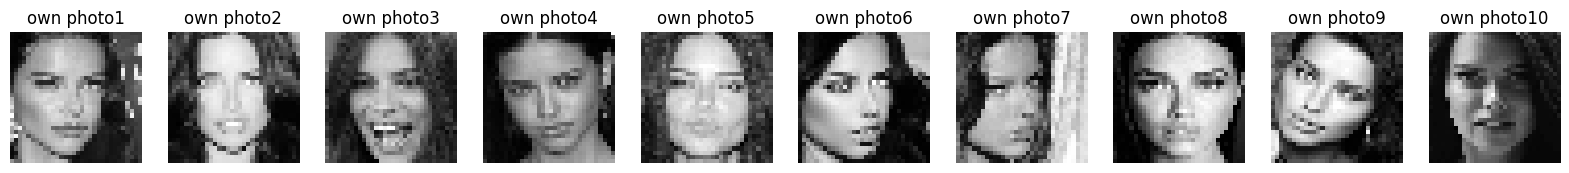

In [49]:
# process own photos
own_imgs = []
own_labels = []

for i in range(1, 11):
    img = cv2.imread('../ca2/data/own/69/' + str(i) + '.jpg', cv2.IMREAD_GRAYSCALE)  # convert to gray image
    img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_CUBIC)
    own_imgs.append(img)  # create imgs in desired format
    own_labels.append(25)  # label own photos as class 69

# split training and testing data sets 
own_train_imgs = own_imgs[0:7]  # first 7 phots for training
own_test_imgs = own_imgs[7:]  # last 3 photos for testing
own_train_labels = own_labels[0:7]
own_test_labels = own_labels[7:]

# visualize photos
fig = plt.figure(figsize=(20, 10))

for i in range(1, 11):
    plt.subplot(1, 10, i)
    plt.imshow(own_imgs[i - 1], cmap='gray')
    plt.title('own photo' + str(i))
    plt.axis('off')

plt.show()

In [50]:
# Train-test split
NUM_TRAIN_IMAGES_PER_SUBJECT = np.int_(np.around(0.7 * 170))

images_train, images_test = np.split(np.array(images), [NUM_TRAIN_IMAGES_PER_SUBJECT], axis=1)
labels_train, labels_test = np.split(np.array(labels), [NUM_TRAIN_IMAGES_PER_SUBJECT], axis=1)
own_images_train, own_images_test = np.split(np.array(own_imgs), [7])
own_labels_train, own_labels_test = np.split(np.array(own_labels), [7])

import warnings

warnings.filterwarnings('ignore', category=Warning)

# Flatterning
PIE_images_train = images_train.reshape(num_subject * NUM_TRAIN_IMAGES_PER_SUBJECT, 1, 32, 32)
own_images_train = own_images_train.reshape(7, 1, 32, 32)
images_test = images_test.reshape(num_subject * (170 - NUM_TRAIN_IMAGES_PER_SUBJECT), 1, 32, 32)
own_images_test = own_images_test.reshape(3, 1, 32, 32)

labels_train = labels_train.reshape(num_subject * NUM_TRAIN_IMAGES_PER_SUBJECT)
labels_test = labels_test.reshape(num_subject * (170 - NUM_TRAIN_IMAGES_PER_SUBJECT))

# Combine PIE images and own photos to get full train and test sets
full_train_set = np.append(PIE_images_train, own_images_train, axis=0, )
full_train_labels = np.append(labels_train, own_labels_train)

full_test_set = np.append(images_test, own_images_test, axis=0, )
full_test_labels = np.append(labels_test, own_labels_test)
# print(full_test_labels[1000])

In [51]:
# Define the model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 20, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(20, 50, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(50 * 5 * 5, 500),
            nn.ReLU(),
            nn.Linear(500, 26)
        )

    def forward(self, x):
        return self.net(x)


# Convert data to torch tensors and datasets
train_set = TensorDataset(torch.Tensor(full_train_set), torch.tensor(full_train_labels).long())
test_set = TensorDataset(torch.Tensor(full_test_set), torch.tensor(full_test_labels).long())

batch_size = 128
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)
model = SimpleCNN()

# Optimization
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)
criterion = nn.CrossEntropyLoss()


# Training loop
def train(model, train_loader, optimizer, criterion, num_epochs=20, device=torch.device('cpu')):
    for epoch in range(num_epochs):

        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        model.train()

        # These are used to record information in training.
        train_loss = []
        train_accs = []

        for batch in tqdm(train_loader):
            #     # Gradients stored in the parameters in the previous step should be cleared out first.
            optimizer.zero_grad()
            # A batch consists of image data and corresponding labels.
            imgs, labels = batch
            # imgs = imgs.half()
            # print(imgs.shape,labels.shape)

            # Forward the data. (Make sure data and model are on the same device.)
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)

            # Calculate the cross-entropy loss.
            # We don't need to apply softmax before computing cross-entropy as it is done automatically.
            loss = criterion(logits, labels)

            # Compute the gradients for parameters.
            loss.backward()

            # Clip the gradient norms for stable training.
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

            # Update the parameters with computed gradients.
            optimizer.step()

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            train_loss.append(loss.item())
            train_accs.append(acc)

        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)

        # Print the information.
        print(f"[ Train | {epoch + 1:03d}/{num_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

        # ---------- Validation ----------
        # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        model.eval()

        # These are used to record information in validation.
        valid_loss = []
        valid_accs = []

        # Iterate the validation set by batches.
        for batch in tqdm(test_loader):
            # A batch consists of image data and corresponding labels.
            imgs, labels = batch
            #imgs = imgs.half()

            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                logits = model(imgs.to(device))

            # We can still compute the loss (but not the gradient).
            loss = criterion(logits, labels.to(device))

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            valid_loss.append(loss.item())
            valid_accs.append(acc)
            #break

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)

        # Print the information.
        print(f"[ Valid | {epoch + 1:03d}/{num_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


In [52]:
# if you have cuda or mac mps, youcan change device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train(model, train_loader, optimizer, criterion)

100%|██████████| 24/24 [00:01<00:00, 20.75it/s]


[ Train | 001/020 ] loss = 3.98673, acc = 0.15675


100%|██████████| 10/10 [00:00<00:00, 76.88it/s]


[ Valid | 001/020 ] loss = 2.26744, acc = 0.40139


100%|██████████| 24/24 [00:01<00:00, 21.10it/s]


[ Train | 002/020 ] loss = 1.39936, acc = 0.60329


100%|██████████| 10/10 [00:00<00:00, 82.64it/s]


[ Valid | 002/020 ] loss = 0.65098, acc = 0.82471


100%|██████████| 24/24 [00:01<00:00, 21.74it/s]


[ Train | 003/020 ] loss = 0.45212, acc = 0.86499


100%|██████████| 10/10 [00:00<00:00, 82.51it/s]


[ Valid | 003/020 ] loss = 0.35004, acc = 0.89663


100%|██████████| 24/24 [00:01<00:00, 21.89it/s]


[ Train | 004/020 ] loss = 0.27562, acc = 0.91769


100%|██████████| 10/10 [00:00<00:00, 84.77it/s]


[ Valid | 004/020 ] loss = 0.24604, acc = 0.93027


100%|██████████| 24/24 [00:01<00:00, 21.64it/s]


[ Train | 005/020 ] loss = 0.12789, acc = 0.96082


100%|██████████| 10/10 [00:00<00:00, 79.90it/s]


[ Valid | 005/020 ] loss = 0.17939, acc = 0.94831


100%|██████████| 24/24 [00:01<00:00, 21.57it/s]


[ Train | 006/020 ] loss = 0.08140, acc = 0.97579


100%|██████████| 10/10 [00:00<00:00, 77.27it/s]


[ Valid | 006/020 ] loss = 0.16028, acc = 0.95538


100%|██████████| 24/24 [00:01<00:00, 20.70it/s]


[ Train | 007/020 ] loss = 0.10892, acc = 0.96440


100%|██████████| 10/10 [00:00<00:00, 78.35it/s]


[ Valid | 007/020 ] loss = 0.17797, acc = 0.94131


100%|██████████| 24/24 [00:01<00:00, 21.41it/s]


[ Train | 008/020 ] loss = 0.08251, acc = 0.97807


100%|██████████| 10/10 [00:00<00:00, 82.69it/s]


[ Valid | 008/020 ] loss = 0.11354, acc = 0.96870


100%|██████████| 24/24 [00:01<00:00, 21.45it/s]


[ Train | 009/020 ] loss = 0.05265, acc = 0.98446


100%|██████████| 10/10 [00:00<00:00, 80.31it/s]


[ Valid | 009/020 ] loss = 0.15729, acc = 0.95848


100%|██████████| 24/24 [00:01<00:00, 21.38it/s]


[ Train | 010/020 ] loss = 0.04361, acc = 0.98730


100%|██████████| 10/10 [00:00<00:00, 79.83it/s]


[ Valid | 010/020 ] loss = 0.15779, acc = 0.96079


100%|██████████| 24/24 [00:01<00:00, 21.36it/s]


[ Train | 011/020 ] loss = 0.04003, acc = 0.99044


100%|██████████| 10/10 [00:00<00:00, 80.85it/s]


[ Valid | 011/020 ] loss = 0.14455, acc = 0.95465


100%|██████████| 24/24 [00:01<00:00, 21.70it/s]


[ Train | 012/020 ] loss = 0.03104, acc = 0.99154


100%|██████████| 10/10 [00:00<00:00, 82.40it/s]


[ Valid | 012/020 ] loss = 0.11285, acc = 0.96942


100%|██████████| 24/24 [00:01<00:00, 21.09it/s]


[ Train | 013/020 ] loss = 0.00849, acc = 0.99870


100%|██████████| 10/10 [00:00<00:00, 79.11it/s]


[ Valid | 013/020 ] loss = 0.09132, acc = 0.97572


100%|██████████| 24/24 [00:01<00:00, 21.46it/s]


[ Train | 014/020 ] loss = 0.00389, acc = 0.99935


100%|██████████| 10/10 [00:00<00:00, 80.67it/s]


[ Valid | 014/020 ] loss = 0.09849, acc = 0.97887


100%|██████████| 24/24 [00:01<00:00, 21.61it/s]


[ Train | 015/020 ] loss = 0.00134, acc = 1.00000


100%|██████████| 10/10 [00:00<00:00, 78.48it/s]


[ Valid | 015/020 ] loss = 0.09983, acc = 0.97651


100%|██████████| 24/24 [00:01<00:00, 21.06it/s]


[ Train | 016/020 ] loss = 0.00069, acc = 1.00000


100%|██████████| 10/10 [00:00<00:00, 79.65it/s]


[ Valid | 016/020 ] loss = 0.09401, acc = 0.97574


100%|██████████| 24/24 [00:01<00:00, 21.38it/s]


[ Train | 017/020 ] loss = 0.00053, acc = 1.00000


100%|██████████| 10/10 [00:00<00:00, 80.38it/s]


[ Valid | 017/020 ] loss = 0.09411, acc = 0.97809


100%|██████████| 24/24 [00:01<00:00, 21.60it/s]


[ Train | 018/020 ] loss = 0.00045, acc = 1.00000


100%|██████████| 10/10 [00:00<00:00, 82.27it/s]


[ Valid | 018/020 ] loss = 0.09497, acc = 0.97809


100%|██████████| 24/24 [00:01<00:00, 21.16it/s]


[ Train | 019/020 ] loss = 0.00040, acc = 1.00000


100%|██████████| 10/10 [00:00<00:00, 77.47it/s]


[ Valid | 019/020 ] loss = 0.09489, acc = 0.97887


100%|██████████| 24/24 [00:01<00:00, 21.60it/s]


[ Train | 020/020 ] loss = 0.00037, acc = 1.00000


100%|██████████| 10/10 [00:00<00:00, 79.19it/s]

[ Valid | 020/020 ] loss = 0.09608, acc = 0.97887


# it also contains test part, in each epoch, it will run test part with no_grad(), therefore it will not affect the gradient.
# And the model in valid dataset has 0.97887 accuracy at last.